#Feature Names

age: Age of the patient

sex: Sex of the patient ~ 0 = Male , 1 = Female

cp: Chest pain type, 0 = Typical Angina, 1 = Atypical Angina, 2 = Non-anginal Pain, 3 = Asymptomatic

trtbps: Resting blood pressure (in mm Hg)

chol: Cholestoral in mg/dl fetched via BMI sensor

fbs: (fasting blood sugar > 120 mg/dl), 1 = True, 0 = False

restecg: Resting electrocardiographic results, 0 = Normal, 1 = ST-T wave normality, 2 = Left ventricular hypertrophy

thalachh: Maximum heart rate achieved

oldpeak: Previous peak

slp: Slope

caa: Number of major vessels

thall: Thalium Stress Test result ~ (0,3)

exng: Exercise induced angina ~ 1 = Yes, 0 = No

output: Target variable

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df=pd.read_csv('heart.csv')
df.drop_duplicates(keep='first',inplace=True)

print(df)

     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
300   68    1   0     144   193    1        1       141     0      3.4    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  output  
0      0      1       1  

In [5]:
%pip install xgboost
%pip install xgboost-sklearn
%pip install shap
%pip install lime

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement xgboost-sklearn (from versions: none)
ERROR: No matching distribution found for xgboost-sklearn


Note: you may need to restart the kernel to use updated packages.

  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=b12a772bde5e4d2af0a3a9e079f56ceae6d15a4f7e19681e5cc5ab79b4c52af8
  Stored in directory: c:\users\dgreat\appdata\local\pip\cache\wheels\ed\d7\c9\5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Set up the data for modelling 
# define Y 
y=df['output'].to_frame() 
# define X df.columns.difference removes the specified column
X=df[df.columns.difference(['output'])] 
# create train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=101)

# build classifier
xgb_mod=xgb.XGBClassifier(random_state=101, gpu_id=0, use_label_encoder = False)

#values.ravel() compresses any array to 1D Array 
xgb_mod=xgb_mod.fit(X_train,y_train.values.ravel())   

#print(xgb_mod)

# make prediction and check model accuracy 
y_pred = xgb_mod.predict(X_test)

# Performance
#Actual Prediction Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.10%


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


EXPECTED VALUE : 0.26300168

Shap Values of 100th Observation :  [ 1.5226028  -2.4421504   0.47713456  2.2208881   0.11948245 -0.09461677
  0.06724507 -0.2911046  -0.50688887  0.6546202   0.32628733  0.8501843
  0.3537679 ]

Sum of Shap Values of 100th Observation :  3.257452130317688

F(x) = Sum of Shap Values + Expected Value =  3.257452130317688  +  0.26300168  =  3.5204538106918335


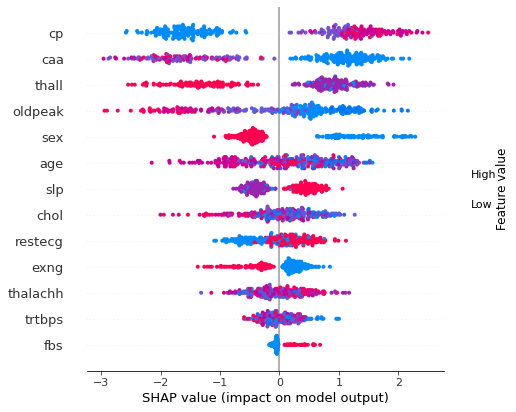

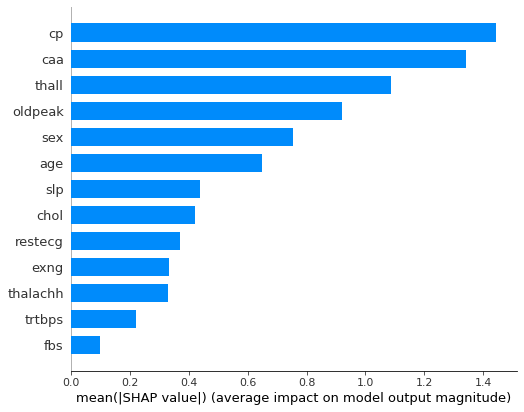

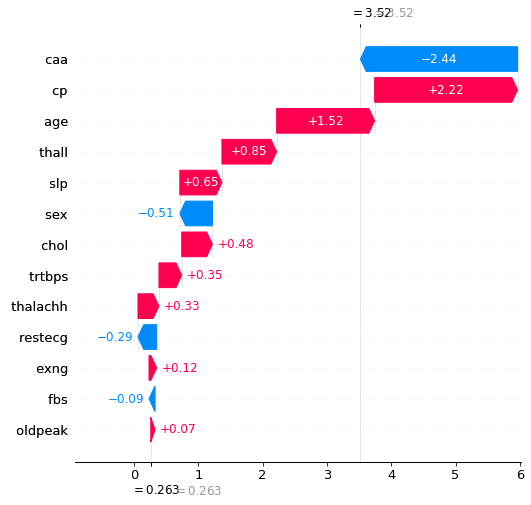

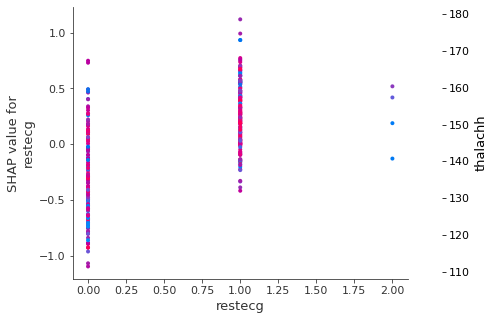

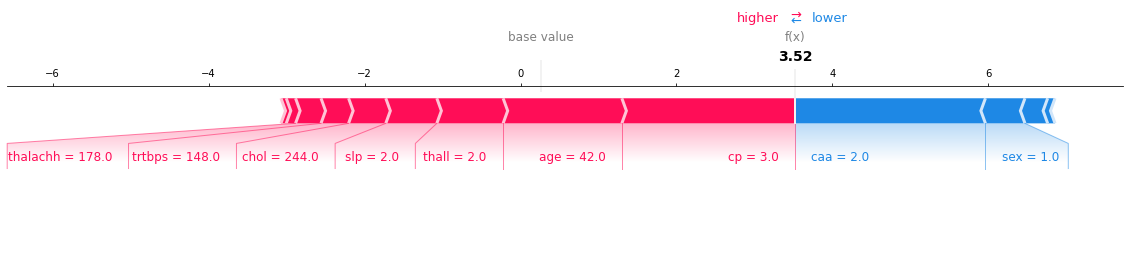

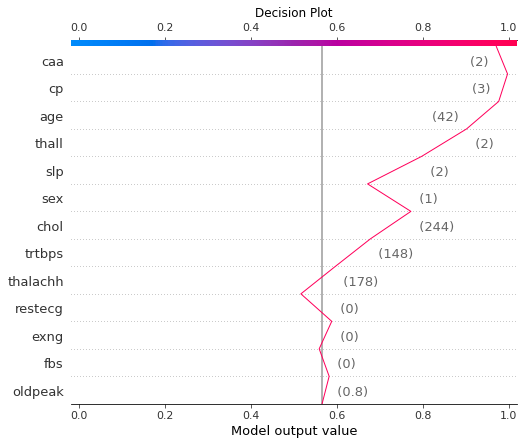

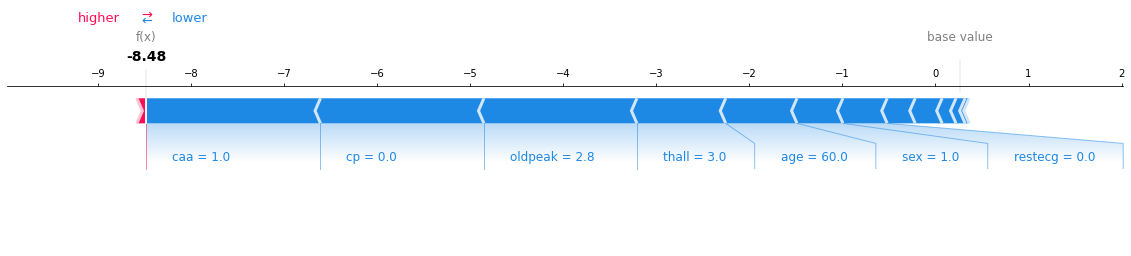

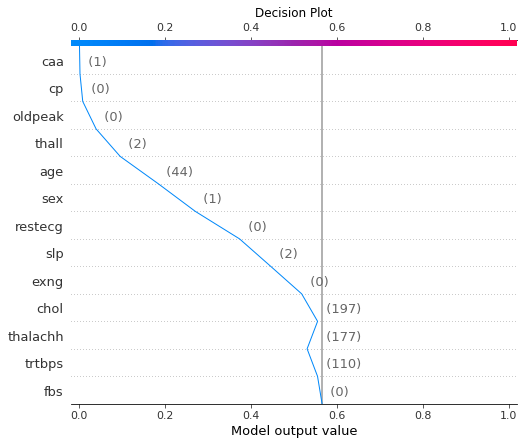

In [7]:
import shap

# Generate the Tree explainer and SHAP values
explainer = shap.TreeExplainer(xgb_mod)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value



print("EXPECTED VALUE :", expected_value)
print()

#f(x)= shap_values[x]+expected_value
s=0
for i in shap_values[100]:
    s=s+i

print("Shap Values of 100th Observation : ", shap_values[100])
print()
print("Sum of Shap Values of 100th Observation : ", s)
print()
print("F(x) = Sum of Shap Values + Expected Value = " , s ," + " , expected_value, " = ", s+expected_value)
############## visualizations #############
# Generate summary dot plot
shap.summary_plot(shap_values, X,title="SHAP summary plot") 

shap.summary_plot(shap_values, X,plot_type="bar") 

# Generate waterfall plot  
shap.plots._waterfall.waterfall_legacy(expected_value, shap_values[100], features=X.loc[100,:], feature_names=X.columns, max_display=15, show=True)

# Generate dependence plot
shap.dependence_plot("restecg", shap_values, X, interaction_index="thalachh")

# Generate summary bar plot 

# Generate force plot - Multiple rows 
shap.force_plot(explainer.expected_value, shap_values[:100,:], X.iloc[:100,:])

# Generate force plot - Single
shap.force_plot(explainer.expected_value, shap_values[100,:], X.iloc[100,:], matplotlib =True)


#shap_value[200] - Blue in decision Plot
#shap_value[100] - Red in decision Plot

shap.decision_plot(expected_value, shap_values[100],link='logit' ,features=X.loc[100,:], feature_names=(X.columns.tolist()),show=True,title="Decision Plot")

shap.force_plot(explainer.expected_value, shap_values[200,:], X.iloc[200,:], matplotlib =True)
shap.decision_plot(expected_value, shap_values[200],link='logit' ,features=X.loc[200,:], feature_names=(X.columns.tolist()),show=True,title="Decision Plot")

